In [2]:
import os, sys
import numpy as np

# Define parameter values
# As: scalar amplitude at k=0.05 Mpc^-1
scalar_amp_values = [2.0e-9, 2.1e-9, 2.2e-9][1:2]
# r: tensor-to-scalar ratio
initial_ratio_values = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01][5:6]

def modify_params_ini(scalar_amp, initial_ratio):
    """Modify parameters in params.ini file"""
    # Read original params.ini file
    with open('params.ini', 'r') as f:
        lines = f.readlines()
    
    # Modify parameters
    for i, line in enumerate(lines):
        if line.strip().startswith('scalar_amp(1)'):
            lines[i] = f'scalar_amp(1)             = {scalar_amp:.1e}\n'
        elif line.strip().startswith('initial_ratio(1)'):
            lines[i] = f'initial_ratio(1)          = {initial_ratio:.3f}\n'
        elif line.strip().startswith('output_root'):
            lines[i] = f'output_root = ./cls/cls_As_{scalar_amp*1e9:.1f}_r_{initial_ratio:.3f}\n'
    
    # Write back to file
    with open('params.ini', 'w') as f:
        f.writelines(lines)

def run_camb_and_save(run_number, scalar_amp, initial_ratio):
    """Run CAMB and save results"""
    as_value = scalar_amp * 1e9  # Convert to 10^-9 units for display
    print(f"Running {run_number}/30: As={as_value:.1f}×10^-9, r={initial_ratio:.3f}")
    
    # Create cls directory if it doesn't exist
    cls_dir = f"cls/cls_As_{as_value:.1f}_r_{initial_ratio:.3f}"
    if not os.path.exists(cls_dir):
        os.makedirs(cls_dir)
    
    # Run CAMB
    result = os.system("./camb/camb params.ini")
    
    if result == 0:
        print(f"Completed run {run_number}: As={as_value:.1f}×10^-9, r={initial_ratio:.3f}")
    else:
        print(f"Error in run {run_number}: CAMB execution failed")
    
    return result

# Main loop
run_number = 0
total_runs = len(scalar_amp_values) * len(initial_ratio_values)
failed_runs = 0

print(f"Starting CAMB calculations with {total_runs} parameter combinations...")
print("="*60)

for scalar_amp in scalar_amp_values:
    for initial_ratio in initial_ratio_values:
        run_number += 1
        
        # Modify parameter file
        modify_params_ini(scalar_amp, initial_ratio)
        
        # Run CAMB and save results
        result = run_camb_and_save(run_number, scalar_amp, initial_ratio)
        if result != 0:
            failed_runs += 1
        
        print("-" * 40)


Starting CAMB calculations with 1 parameter combinations...
Running 1/30: As=2.1×10^-9, r=0.006
Reion redshift       =  12.541
Om_b h^2             =  0.022000
Om_c h^2             =  0.122000
Om_nu h^2            =  0.060000
Om_Lambda            =  0.552263
Om_K                 =  0.000000
Om_m (1-Om_K-Om_L)   =  0.447737
100 theta (CosmoMC)  =  1.112482
N_eff (total)        =  3.046000
 1 nu, g= 1.0153 m_nu*c^2/k_B/T_nu0=  33160.58 (m_nu=  5.580 eV)
Reion opt depth      =  0.0900
Age of universe/GYr  =  12.439
zstar                =  1094.78
r_s(zstar)/Mpc       =  133.80
100*theta            =  1.113015
DA(zstar)/Gpc        =  12.02135
zdrag                =  1062.68
r_s(zdrag)/Mpc       =  136.30
k_D(zstar) Mpc       =  0.1544
100*theta_D          =  0.169253
z_EQ (if v_nu=1)     =  3441.17
k_EQ Mpc (if v_nu=1) =  0.011281
100*theta_EQ         =  0.896895
100*theta_rs_EQ      =  0.496423
tau_recomb/Mpc       =  259.02  tau_now/Mpc =  12280.0

 HMcode: Running HMcode

 HM_cosmology:

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


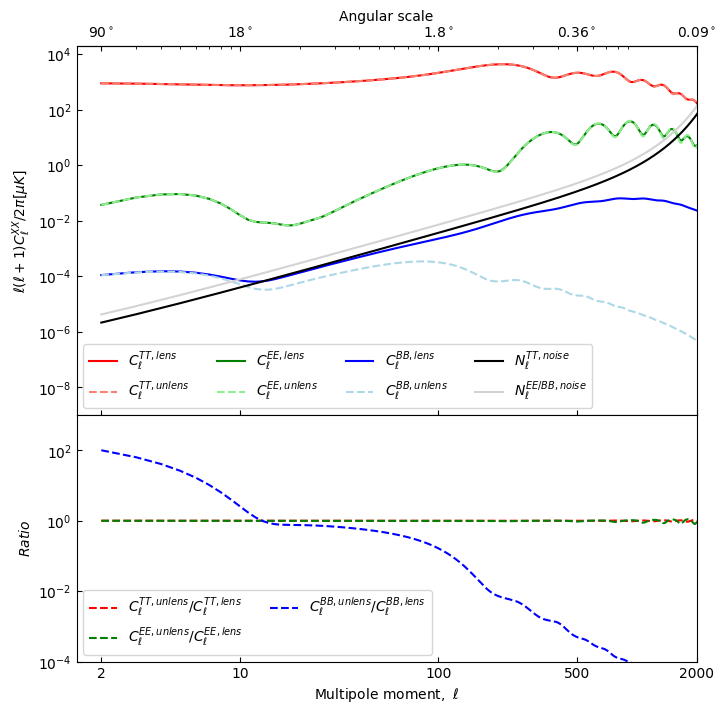

In [1]:
import os
import pylab as pl
import numpy as np
import lenspyx
import healpy as hp
from lenspyx.utils import camb_clfile
from lenspyx.utils_hp import synalm, almxfl, alm2cl
from lenspyx import synfast
import matplotlib.pyplot as plt
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

def sensity(ls, net):
    return net*net/np.exp(-1*ls*(ls+1)*theta*theta/8/np.log(2))



As = [2.0e-9, 2.1e-9, 2.2e-9][1:2]
# r: tensor-to-scalar ratio
rs = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01][5:6]



splt = int(len(As)*len(rs))
lenmaps = []; unlenmaps = []; lenmap_arrs = []; unlenmap_arrs = []
nside = 2048; cls_path = './cls/'


lmax_len = 6000 # desired lmax of the lensed field.
dlmax = 1024  # lmax of the unlensed fields is lmax + dlmax.  (some buffer is required for accurate lensing at lmax)
epsilon = 1e-6 # target accuracy of the output maps (execution time has a fairly weak dependence on this)
lmax_unl, mmax_unl = lmax_len + dlmax, lmax_len + dlmax
lmax_len, mmax_len = lmax_unl,  mmax_unl

a = As[0]; r = rs[0]
lensCL = camb_clfile(os.path.join(cls_path, 'cls_As_%0.1f_r_%0.3f_lensedCls.dat'%(a*1e9, r)))
unlensCL = camb_clfile(os.path.join(cls_path, 'cls_As_%0.1f_r_%0.3f_lenspotentialCls.dat'%(a*1e9, r)))

field0 = 'TT'
field='EE'
field1='BB'

ls = np.arange(2, nside)
factor = ls*(ls+1)/2/np.pi
net = 2.1; fsky = 0.8; ndet = 1020; Y = 1; deltaT = 24*3600
theta = 7.9/60*np.pi/180

noise_T = sensity(ls, 1.5/1e3)
noise_P = sensity(ls, 2.1/1e3)

#print(noise_E[-10:])
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(2, 1, hspace=0, wspace=0, width_ratios=[1], height_ratios=[1.5, 1])
ax1, ax2 = gs.subplots(sharex='col', sharey='row')
# ax1.plot(ls, factor*lensCL['tt'][ls], label = r"$C_\ell^{%s, lens}$"%field, c='blue')
# ax1.plot(ls, factor*unlensCL['tt'][ls], label = r"$C_\ell^{%s, unlens}$"%field, c='orange')
# ax1.plot(ls, noise, label = r"$Noise$", c='orange')
ax1.loglog(ls, factor*lensCL['%s'%field0.lower()][ls], label = r"$C_\ell^{%s, lens}$"%field0, c='red')
ax1.loglog(ls, factor*unlensCL['%s'%field0.lower()][ls], label = r"$C_\ell^{%s, unlens}$"%field0, c='salmon', linestyle='--')


ax1.loglog(ls, factor*lensCL['%s'%field.lower()][ls], label = r"$C_\ell^{%s, lens}$"%field, c='green')
ax1.loglog(ls, factor*unlensCL['%s'%field.lower()][ls], label = r"$C_\ell^{%s, unlens}$"%field, c='lightgreen', linestyle='--')


ax1.loglog(ls, factor*(lensCL['%s'%field1.lower()][ls] + unlensCL['%s'%field1.lower()][ls]), label = r"$C_\ell^{%s, lens}$"%field1, c='blue')
ax1.loglog(ls, factor*unlensCL['%s'%field1.lower()][ls], label = r"$C_\ell^{%s, unlens}$"%field1, c='lightblue', linestyle='--')

ax1.loglog(ls, factor*noise_T, label = r"$N_\ell^{TT, noise}$", c='black')#, linestyle='-')
ax1.loglog(ls, factor*noise_P, label = r"$N_\ell^{EE/BB, noise}$", c='lightgrey')#, linestyle='--')

ax1.set_xlim(1.5, 2000)
ax1.set_xticks([2, 10, 100, 500, 2000])
ax1.set_xticklabels(['2', '10', '100', '500', '2000'])
ax1.set_ylim(1e-9, 2e4)
ax1.set_yticks([1e-8, 1e-6, 1e-4, 1e-2,  1e0, 1e2, 1e4])
ax1.set_yticklabels([r'$10^{-8}$', r'$10^{-6}$', r'$10^{-4}$',  r'$10^{-2}$', r'$10^{0}$', r'$10^2$', r'$10^4$'])
ax1.set_ylabel(r"$\ell(\ell+1)C^{XX}_\ell/2\pi[\mu K]$")
ax1.legend(loc='best', ncol=4)


ax_top = ax1.twiny()
ax_top.spines.top.set_position(("axes", 1))  # 调整上部axis的位置
ax_top.set_xscale("log")
ax_top.set_xlim(1.5, 2000)
ax_top.set_xticks([2, 10, 100, 500, 2000])
ax_top.set_xticklabels([r'$90^\circ$', r'$18^\circ$', r'$1.8^\circ$', r'$0.36^\circ$', r'$0.09^\circ$'])
ax_top.set_xlabel("Angular scale")
ax_top.spines['left'].set_visible(False)
ax_top.spines['bottom'].set_visible(False)
ax_top.spines['right'].set_visible(False)

ax2.loglog(ls, unlensCL['%s'%field0.lower()][ls]/lensCL['%s'%field0.lower()][ls], label = r"$C_\ell^{%s, unlens}/C_\ell^{%s, lens}$"%(field0, field0), color='red', linestyle='--')
ax2.loglog(ls, unlensCL['%s'%field.lower()][ls]/lensCL['%s'%field.lower()][ls], label = r"$C_\ell^{%s, unlens}/C_\ell^{%s, lens}$"%(field, field), color='green', linestyle='--')
ax2.loglog(ls, unlensCL['%s'%field1.lower()][ls]/lensCL['%s'%field1.lower()][ls], label = r"$C_\ell^{%s, unlens}/C_\ell^{%s, lens}$"%(field1, field1), color='blue', linestyle='--')
#ax2.loglog(ls, ls/ls, color='gray', label=r'$Ratio=1$')

ax2.minorticks_off()
ax2.set_xlabel(r"$\rm{Multipole~moment,}~\ell$")
ax2.set_ylabel(r"$Ratio$")
ax2.set_ylim(1e-4, 1e3)
ax2.set_yticks([1e-4, 1e-2, 1e0, 1e2])
ax2.set_yticklabels([r'$10^{-4}$', r'$10^{-2}$',  r'$10^{0}$', r'$10^{2}$'])
ax2.set_xlim(1.5, 2000)
ax2.set_xticks([2, 10, 100, 500, 2000])
ax2.set_xticklabels(['2', '10', '100', '500', '2000'])
ax2.set_ylabel(r"$Ratio$")
ax2.legend(ncol=2, loc='lower left')


for ax in fig.get_axes():
    ax.label_outer()
plt.savefig("TT_EE_BB_cl_ratio.pdf", bbox_inches='tight', pad_inches=0, dpi=300, format='pdf')
plt.show()
